In [1]:
import pandas as pd
import numpy as np

import re

# Read the dataset into the notebook

In [2]:
df = pd.read_excel(r'prescription_cost.xlsx')
df.head()

,BNF chemical name,Drug/device name,Drug formulation,Drug strength,Item description,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),Cost per item (£),Quantity per item
0,ABACAVIR,ABACAVIR,TABS,300 MG,NaN,HIV INFECTION,50301,23,1232.0,4290.44,186.540870,53.565217
1,ABACAVIR AND LAMIVUDINE,ABACAVIR AND LAMIVUDINE,TABS,NaN,600MG/300MG,HIV INFECTION,50301,24,678.0,6171.05,257.127083,28.250000
2,ABACAVIR AND LAMIVUDINE,KIVEXA,TABS,NaN,NaN,HIV INFECTION,50301,2,58.0,681.02,340.510000,29.000000
3,"ABACAVIR, LAMIVUDINE AND DOLUTEGRAVIR",TRIUMEQ,TABS,NaN,NaN,HIV INFECTION,50301,663,21120.0,561106.48,846.314449,31.855204
4,ABATACEPT,ABATACEPT,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED SYRINGE,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,4.0,1209.60,1209.600000,4.000000


# Make a chart of the NaN values

In [4]:
df.shape

(11741, 12)

In [3]:
def missing_value_describe(data):
    # check missing values in the data
    total = data.isna().sum().sort_values(ascending=False)
    missing_value_pct_stats = (data.isnull().sum() / len(data)*100)
    missing_value_col_count = sum(missing_value_pct_stats > 0)

    # missing_value_stats = missing_value_pct_stats.sort_values(ascending=False)[:missing_value_col_count]
    missing_data = pd.concat([total, missing_value_pct_stats], axis=1, keys=['Total', 'Percentage(%)'])

    print("Number of rows with at least 1 missing values:", data.isna().any(axis = 1).sum())
    print("Number of columns with missing values:", missing_value_col_count)

    if missing_value_col_count != 0:
        # print out column names with missing value percentage
        print("\nMissing percentage (desceding):")
        display(missing_data[:missing_value_col_count])

        # plot missing values
        missing = data.isnull().sum()
        missing = missing[missing > 0]
        missing.sort_values(inplace=True)
        missing.plot.bar(figsize=(10,8))
    else:
        print("No missing data!!!")

Number of rows with at least 1 missing values: 9226
Number of columns with missing values: 4

Missing percentage (desceding):


,Total,Percentage(%)
Drug strength,6062,51.631037
Drug formulation,4668,39.758113
Item description,4624,39.383357
BNF sub-section,1,0.008517


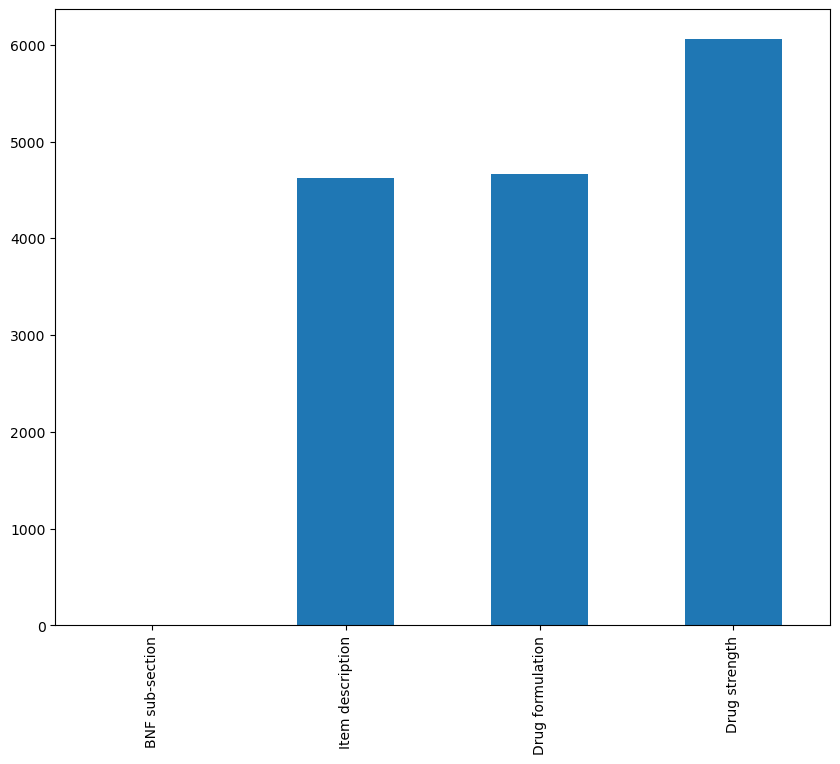

In [4]:
missing_value_describe(df)

# Drop the unwanted columns to reduce the NAN values

As you can see in the chart above item description, drug formulation, and drug strength has a high percentage of NaN values, so we need to drop them so as to get a desired result.

In [5]:
df.drop(columns="Item description", inplace = True)
df.drop(columns="Drug formulation", inplace = True)

Number of rows with at least 1 missing values: 6062
Number of columns with missing values: 2

Missing percentage (desceding):


,Total,Percentage(%)
Drug strength,6062,51.631037
BNF sub-section,1,0.008517


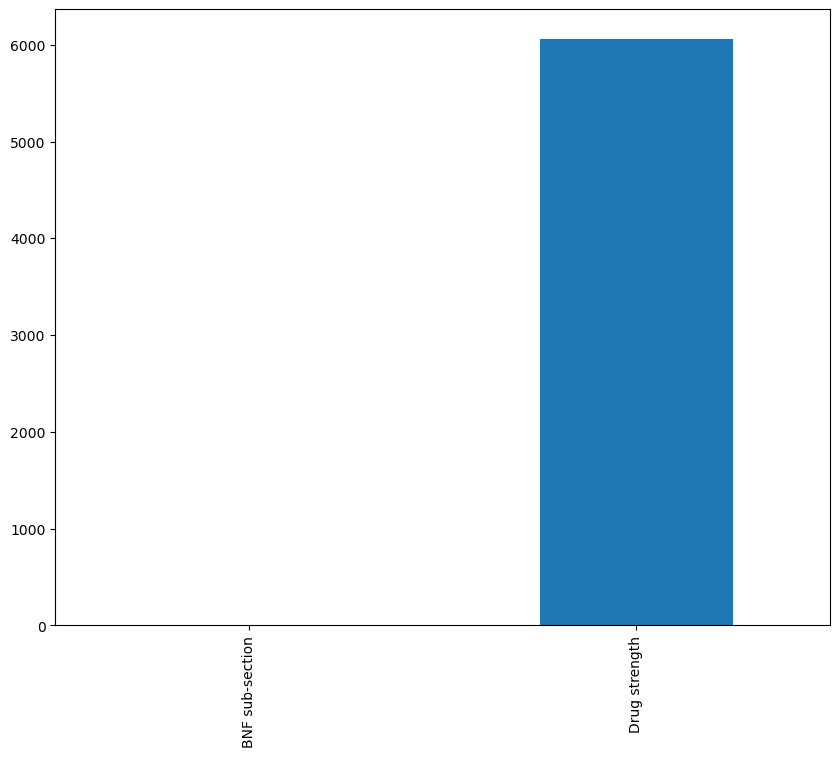

In [6]:
missing_value_describe(df)

In [7]:
df.dropna(inplace = True)
df.head()

,BNF chemical name,Drug/device name,Drug strength,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),Cost per item (£),Quantity per item
0,ABACAVIR,ABACAVIR,300 MG,HIV INFECTION,50301,23,1232.0,4290.44,186.540870,53.565217
4,ABATACEPT,ABATACEPT,125 MG/1ML,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,4.0,1209.60,1209.600000,4.000000
5,ABATACEPT,ORENCIA,125 MG/1ML,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,1.0,302.40,302.400000,1.000000
6,ABIRATERONE,ABIRATERONE,500 MG,HORMONE ANTAGONISTS,80304,7920,438990.0,21389480.55,2700.691989,55.428030
7,ABIRATERONE,ZYTIGA,500 MG,HORMONE ANTAGONISTS,80304,176,9793.0,478283.13,2717.517784,55.642045


Now we are left with drug strength which is our main objective to explore.

# Data Exploration

Convert all the grams, milligrams, nanograms, and extract the numerical values of the Milli-litres.

In [8]:
import re
import numpy as np
def extract_mg_value(value):
    if pd.notna(value):
        # Extract numerical value followed by "MG"
        kg_match = re.search(r'(\d+\.?\d*)\s*(KG)', value, re.IGNORECASE)
        if kg_match:
            return float(kg_match.group(1))
        g_match = re.search(r'(\d+\.?\d*)\s*(G)', value, re.IGNORECASE)
        if g_match:
            return float(g_match.group(1)) / 1000
        mg_match = re.search(r'(\d+\.?\d*)\s*(MG)', value, re.IGNORECASE)
        if mg_match:
            return float(mg_match.group(1)) / 1000000
        
        # Extract numerical value followed by "MCG" (micrograms)
        mcg_match = re.search(r'(\d+\.?\d*)\s*(MCG)', value, re.IGNORECASE)
        if mcg_match:
            return float(mcg_match.group(1)) / 1000000000.0  # Convert micrograms to milligrams
        nan_match = re.search(r'(\d+\.?\d*)\s*(NANOGRAMS)', value, re.IGNORECASE)
        if nan_match:
            return float(nan_match.group(1)) / 1000000000000.0
        
        # Extract numerical value followed by "ML" or "dose" (assuming it's in milligrams)
        ml_dose_match = re.search(r'(\d+\.?\d*)\s*(ML|dose)', value, re.IGNORECASE)
        if ml_dose_match:
            return float(ml_dose_match.group(1)) / 1000000000000000
        
        # If none of the patterns match, return NaN
        return np.nan

# Apply the extract_mg_value function to the 'Value' column to get the mg values
df['KG Value'] = df['Drug strength'].apply(extract_mg_value)

In [9]:
df["Consumed_Drug(KG)"] = df["KG Value"] * df["Dispensed quantity"]

In [10]:
df.head()

,BNF chemical name,Drug/device name,Drug strength,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),Cost per item (£),Quantity per item,KG Value,Consumed_Drug(KG)
0,ABACAVIR,ABACAVIR,300 MG,HIV INFECTION,50301,23,1232.0,4290.44,186.540870,53.565217,0.000300,0.369600
4,ABATACEPT,ABATACEPT,125 MG/1ML,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,4.0,1209.60,1209.600000,4.000000,0.000125,0.000500
5,ABATACEPT,ORENCIA,125 MG/1ML,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,1.0,302.40,302.400000,1.000000,0.000125,0.000125
6,ABIRATERONE,ABIRATERONE,500 MG,HORMONE ANTAGONISTS,80304,7920,438990.0,21389480.55,2700.691989,55.428030,0.000500,219.495000
7,ABIRATERONE,ZYTIGA,500 MG,HORMONE ANTAGONISTS,80304,176,9793.0,478283.13,2717.517784,55.642045,0.000500,4.896500


In [11]:
A= df.groupby("BNF chemical name")["BNF sub-section"].sum().reset_index()
B= df.groupby("BNF chemical name")["BNF sub-section.1"].sum().reset_index()
C= df.groupby("BNF chemical name")["Number of dispensed items"].sum().reset_index()
D= df.groupby("BNF chemical name")["Gross ingredient cost (£)"].sum().reset_index()
E= df.groupby("BNF chemical name")["Dispensed quantity"].sum().reset_index()
F= df.groupby("BNF chemical name")["Cost per item (£)"].sum().reset_index()
G= df.groupby("BNF chemical name")["Quantity per item"].sum().reset_index()
H= df.groupby("BNF chemical name")["KG Value"].sum().reset_index()
total_consumed_drug = df.groupby("BNF chemical name")["Consumed_Drug(KG)"].sum().reset_index()
I=df.groupby("BNF chemical name")["Cost per item (£)"].sum().reset_index()

In [12]:
total_consumed_drug=total_consumed_drug.sort_values("Consumed_Drug(KG)", ascending = False)
# # total_consumed_drug = total_consumed_drug[total_consumed_drug["Consumed_Drug(KG)"] != max_value]
total_consumed_drug.head()

,BNF chemical name,Consumed_Drug(KG)
489,LACTULOSE,745864.885000
669,PARACETAMOL,180319.679770
567,METFORMIN HYDROCHLORIDE,96479.794512
473,ISPAGHULA HUSK,36654.487830
389,GABAPENTIN,30898.145400


In [13]:
dfs = [A, B, C, D, E, I, total_consumed_drug]
import functools as ft
df_fina = ft.reduce(lambda left, right:pd.merge(left, right, on ="BNF chemical name"), dfs)
df_fina.head()

,BNF chemical name,BNF sub-section,BNF sub-section.1,Number of dispensed items,Gross ingredient cost (£),Dispensed quantity,Cost per item (£),Consumed_Drug(KG)
0,ABACAVIR,HIV INFECTION,50301,23,4290.44,1232.0,186.540870,0.369600
1,ABATACEPT,RHEUMATIC DISEASE SUPPRESSANT DRUGSRHEUMATIC D...,200206,2,1512.00,5.0,1512.000000,0.000625
2,ABIRATERONE,HORMONE ANTAGONISTSHORMONE ANTAGONISTS,160608,8096,21867763.68,448783.0,5418.209773,224.391500
3,ACAMPROSATE CALCIUM,ALCOHOL DEPENDENCEALCOHOL DEPENDENCE,82002,34703,1141008.21,5677488.0,64.447082,1890.603504
4,ACARBOSE,ANTIDIABETIC DRUGSANTIDIABETIC DRUGS,120204,740,16068.88,81478.0,51.064783,5.299800


In [14]:
A = total_consumed_drug.drop(total_consumed_drug[(total_consumed_drug["BNF chemical name"]== "LACTULOSE") | (total_consumed_drug["BNF chemical name"] == "GLUCOSE")]. index)
A.head()

,BNF chemical name,Consumed_Drug(KG)
669,PARACETAMOL,180319.679770
567,METFORMIN HYDROCHLORIDE,96479.794512
473,ISPAGHULA HUSK,36654.487830
389,GABAPENTIN,30898.145400
615,NAPROXEN,21547.092000


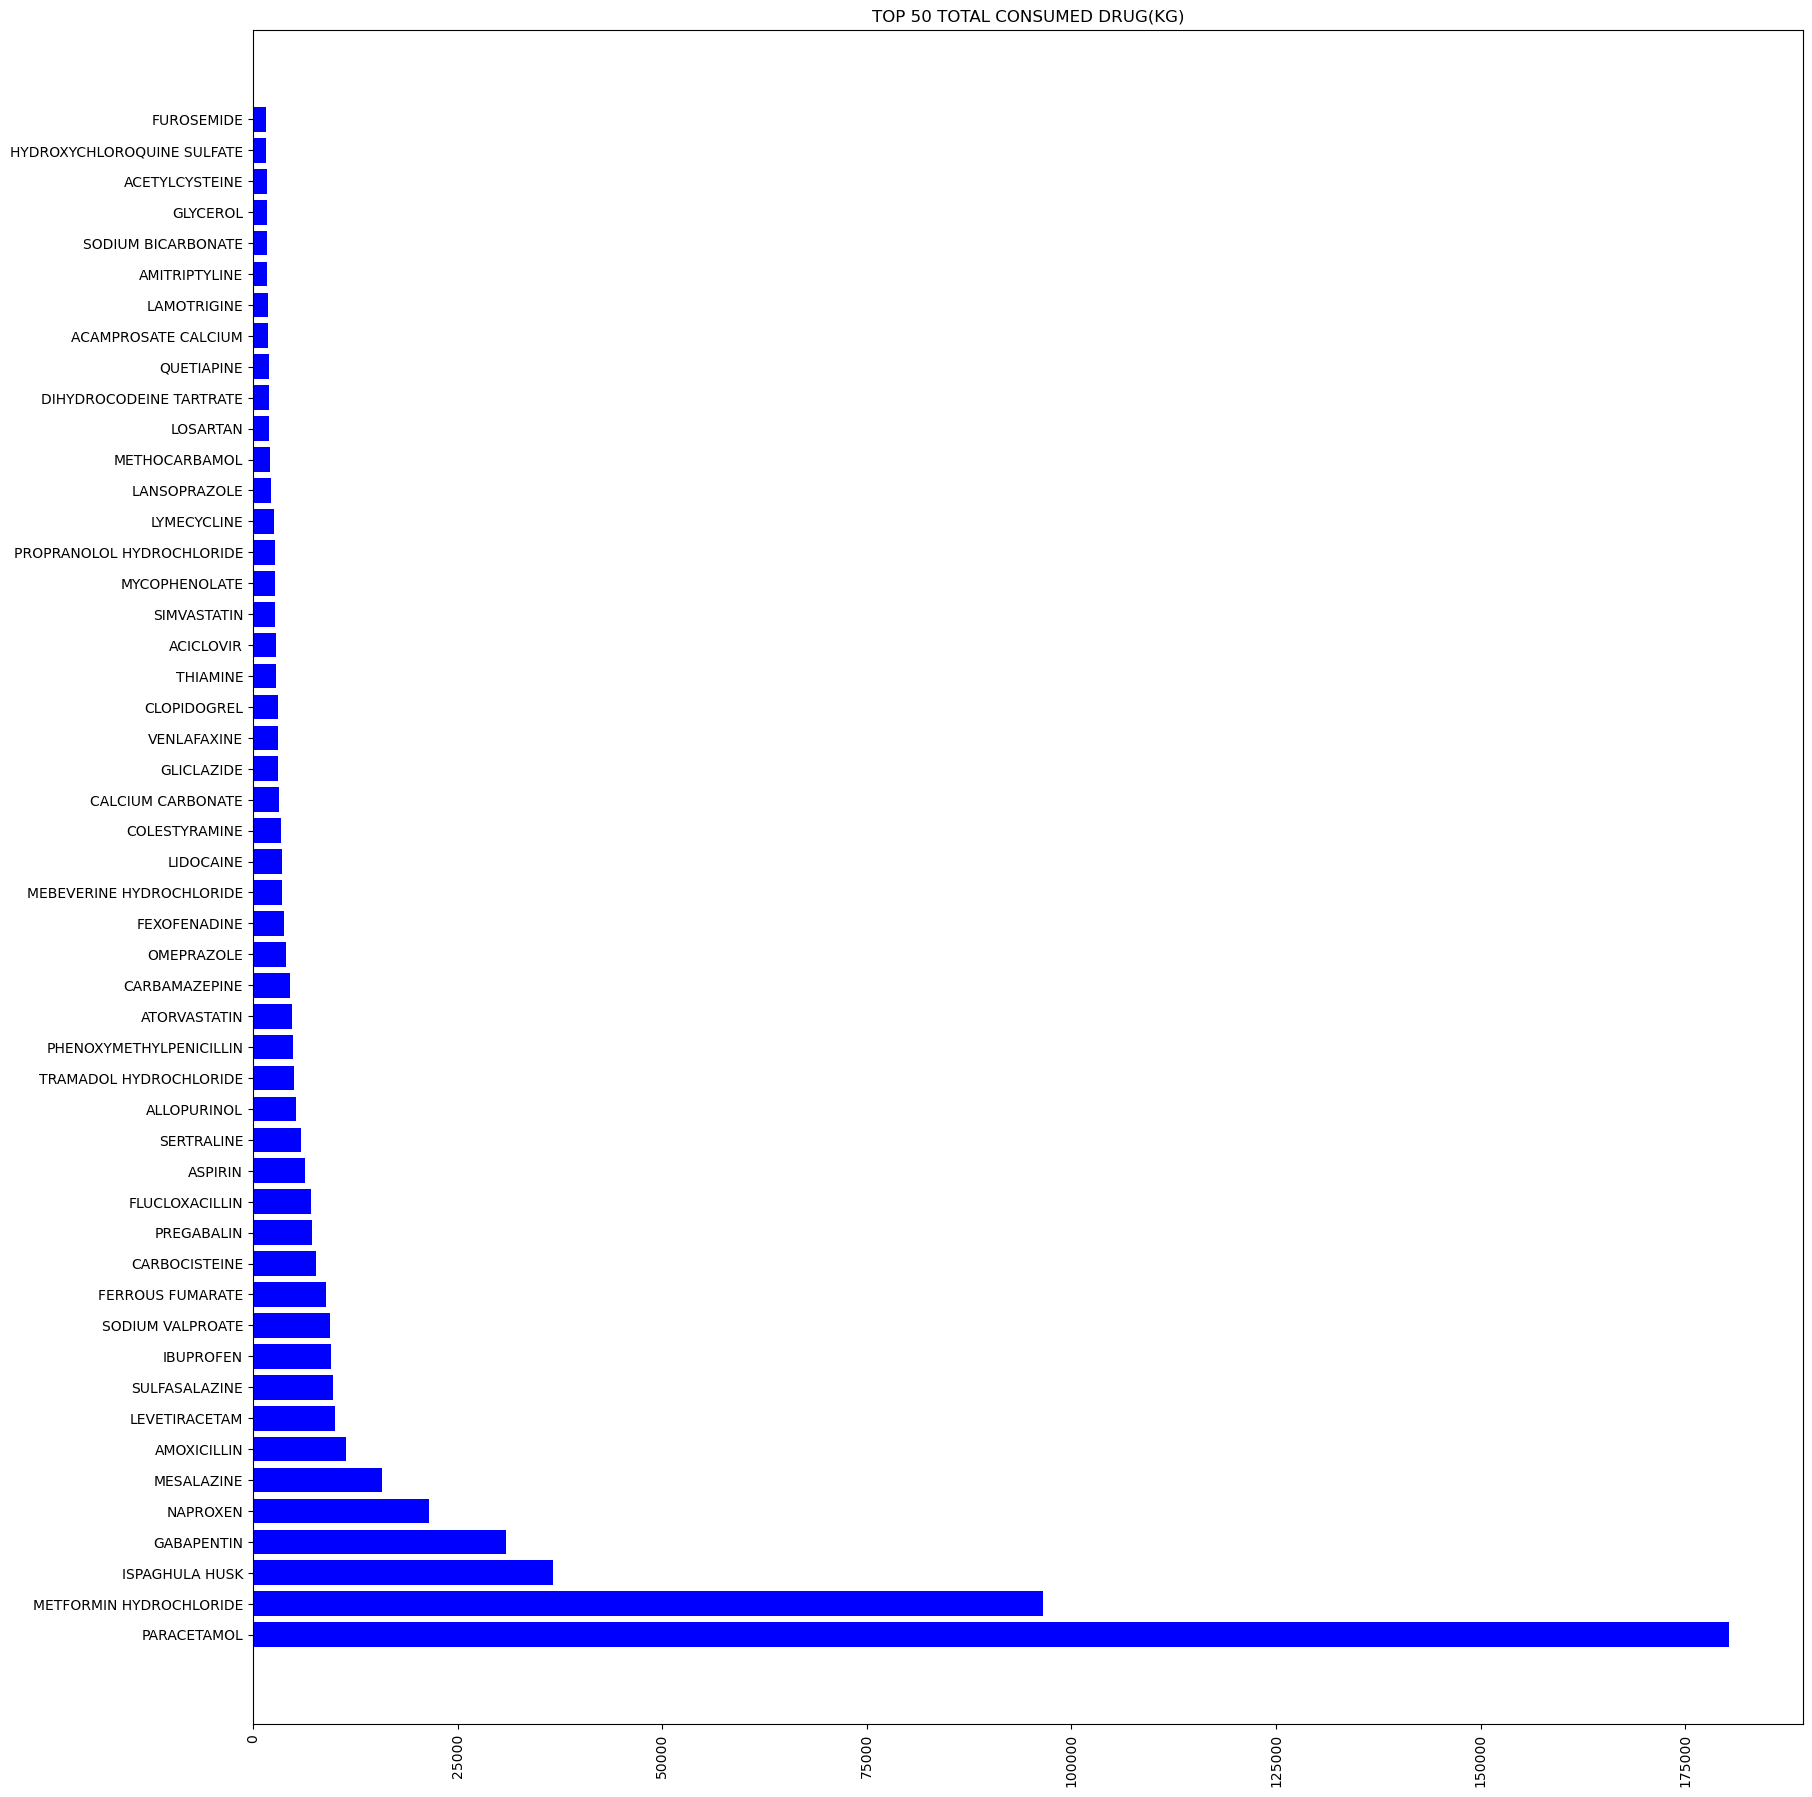

In [15]:
import matplotlib.pyplot as plt
# total_consumed_drug = total_consumed_drug.sort_values("Consumed_Drug(KG)")
top_20 = A.head(50)
top_20
plt.figure(figsize = (20, 22))
plt.barh(top_20["BNF chemical name"], top_20["Consumed_Drug(KG)"], color = "blue")
plt.title("TOP 50 TOTAL CONSUMED DRUG(KG)")
plt.xticks(rotation=90)
plt.show();

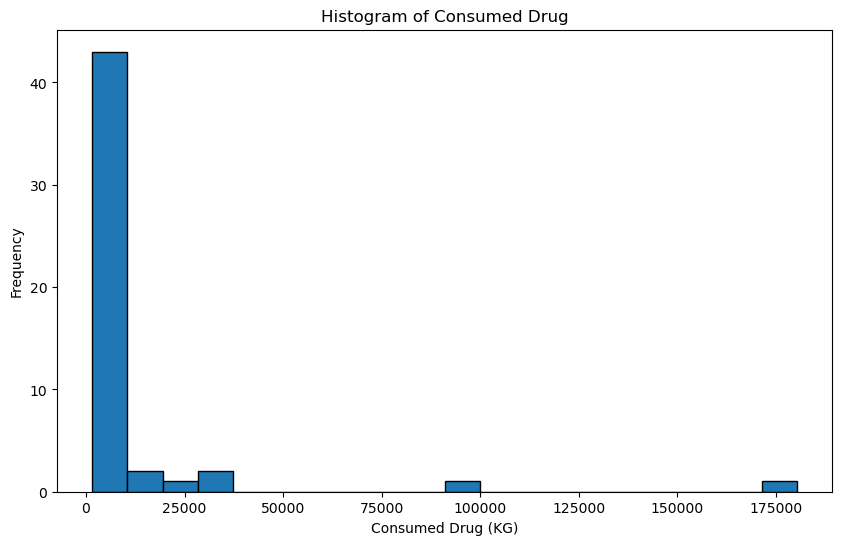

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(top_20['Consumed_Drug(KG)'], bins=20, edgecolor='black')
plt.xlabel('Consumed Drug (KG)')
plt.ylabel('Frequency')
plt.title('Histogram of Consumed Drug')
plt.show()

In [17]:
total_disease_group=df_fina.groupby("BNF sub-section")["Consumed_Drug(KG)"].sum().reset_index()
# # total_consumed_drug = total_consumed_drug[total_consumed_drug["Consumed_Drug(KG)"] != max_value]
total_disease_group.head()

,BNF sub-section,Consumed_Drug(KG)
0,ADRENOCEPTOR AGONISTSADRENOCEPTOR AGONISTS,1.169200e-01
1,ADRENOCEPTOR AGONISTSADRENOCEPTOR AGONISTSADRE...,2.075000e-07
2,ADRENOCEPTOR AGONISTSADRENOCEPTOR AGONISTSADRE...,7.066500e-04
3,ADRENOCEPTOR AGONISTSADRENOCEPTOR AGONISTSADRE...,1.714250e-01
4,ADRENOCEPTOR AGONISTSADRENOCEPTOR AGONISTSADRE...,9.979200e-05


In [18]:
total_disease_group = total_disease_group.sort_values("BNF sub-section", ascending = False)
total_disease_group.head(10)

,BNF sub-section,Consumed_Drug(KG)
658,ZINC AND OTHER MINERALSZINC AND OTHER MINERALS...,8.101095
657,VITAMIN KVITAMIN KVITAMIN KVITAMIN KVITAMIN KV...,0.057301
656,VITAMIN K,0.152940
655,VITAMIN EVITAMIN EVITAMIN EVITAMIN E,67.800000
654,VITAMIN DVITAMIN DVITAMIN DVITAMIN DVITAMIN DV...,14.655104
653,VITAMIN DVITAMIN DVITAMIN DVITAMIN DVITAMIN DV...,0.000679
652,VITAMIN DVITAMIN DPREPARATIONS FOR PSORIASISVI...,0.003179
651,VITAMIN DVITAMIN D,0.000000
650,VITAMIN D,0.004455
649,VITAMIN CVITAMIN CVITAMIN CVITAMIN CVITAMIN CV...,132.951500


In [19]:
top_50 = total_disease_group.head(50)
top_50

,BNF sub-section,Consumed_Drug(KG)
658,ZINC AND OTHER MINERALSZINC AND OTHER MINERALS...,8.101095
657,VITAMIN KVITAMIN KVITAMIN KVITAMIN KVITAMIN KV...,0.057301
656,VITAMIN K,0.152940
655,VITAMIN EVITAMIN EVITAMIN EVITAMIN E,67.800000
654,VITAMIN DVITAMIN DVITAMIN DVITAMIN DVITAMIN DV...,14.655104
653,VITAMIN DVITAMIN DVITAMIN DVITAMIN DVITAMIN DV...,0.000679
652,VITAMIN DVITAMIN DPREPARATIONS FOR PSORIASISVI...,0.003179
651,VITAMIN DVITAMIN D,0.000000
650,VITAMIN D,0.004455
649,VITAMIN CVITAMIN CVITAMIN CVITAMIN CVITAMIN CV...,132.951500


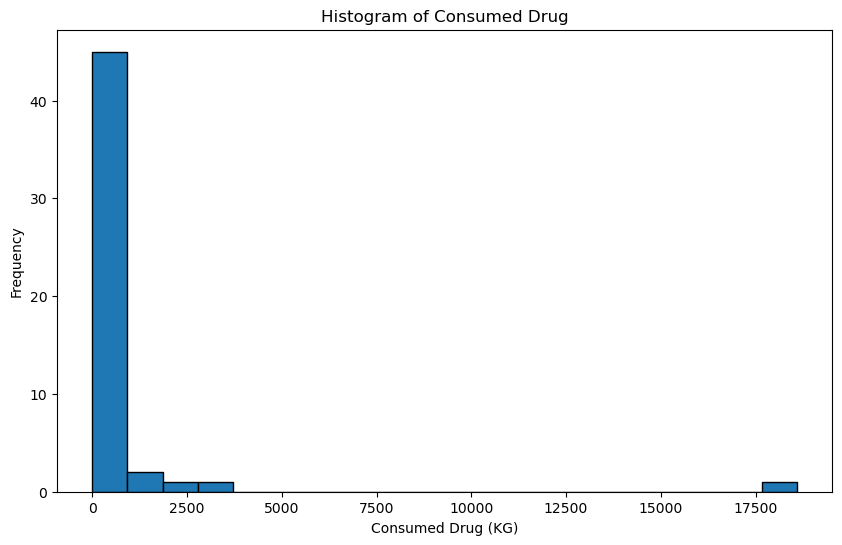

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(top_50['Consumed_Drug(KG)'], bins=20, edgecolor='black')
plt.xlabel('Consumed Drug (KG)')
plt.ylabel('Frequency')
plt.title('Histogram of Consumed Drug')
plt.show()

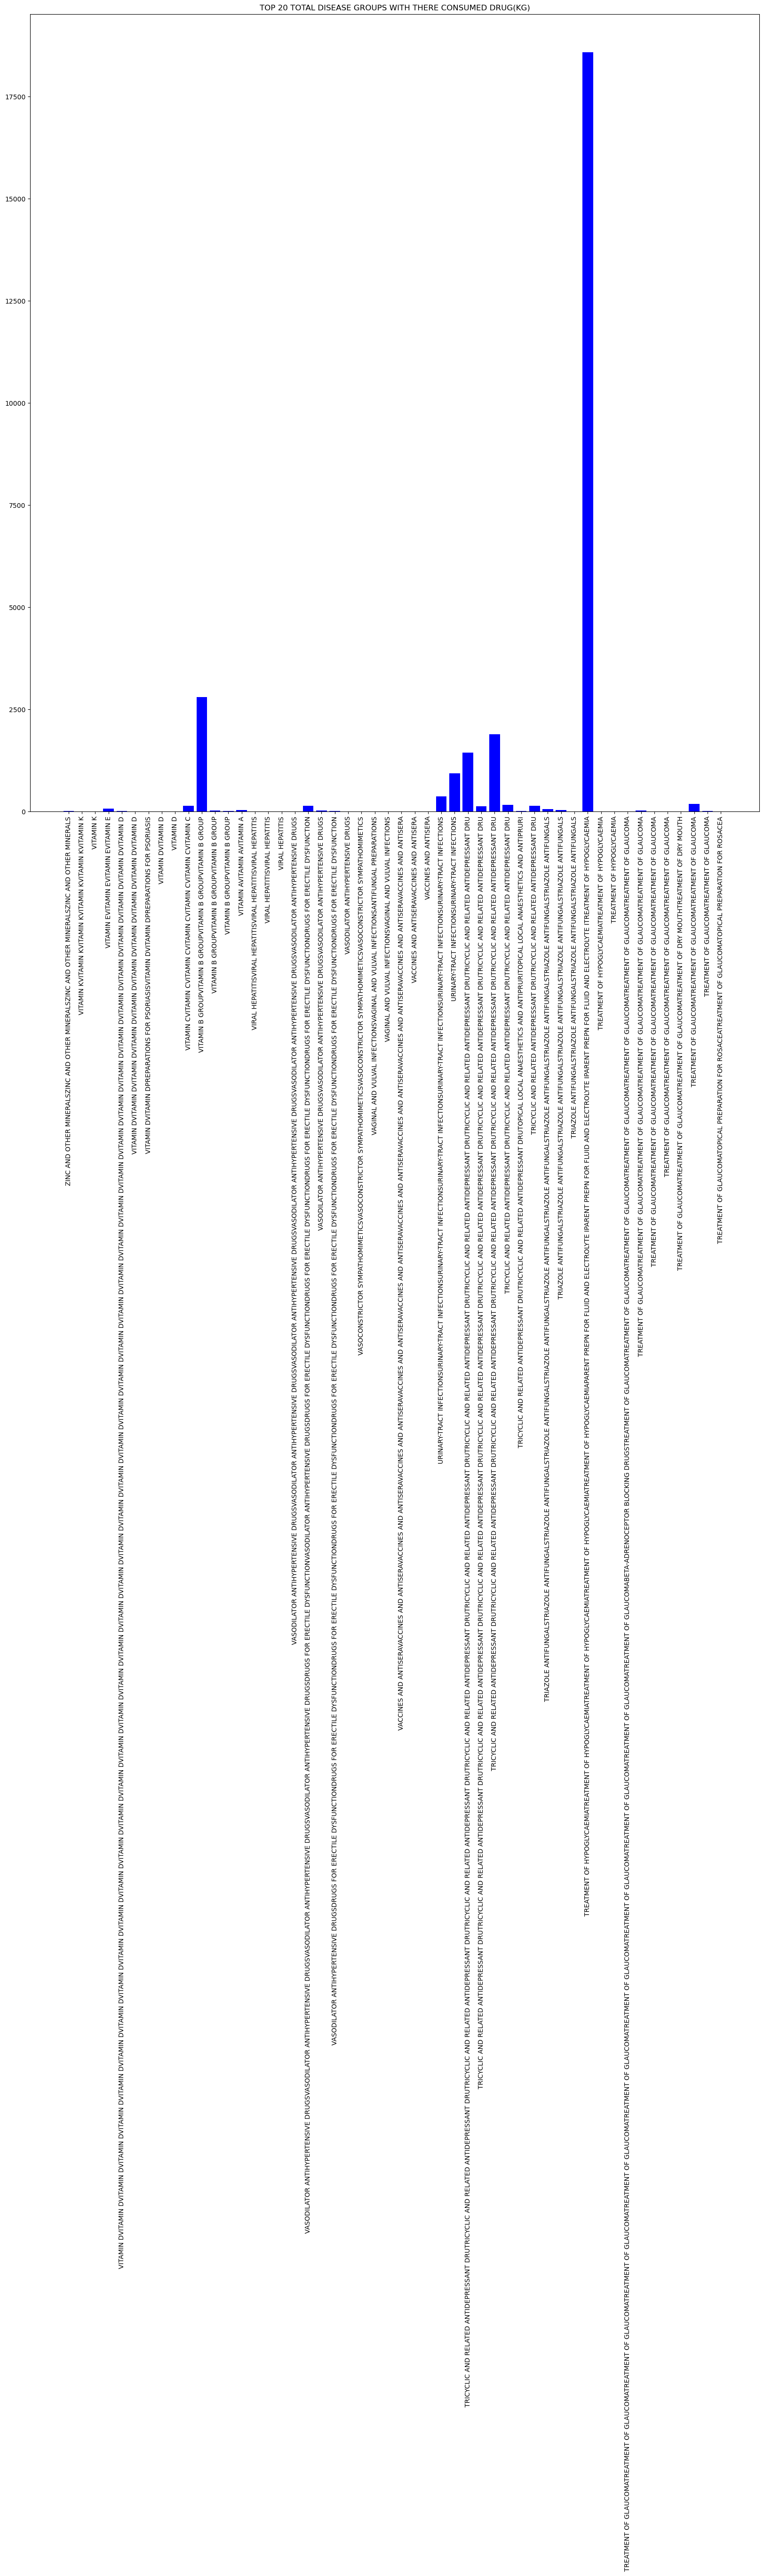

In [21]:
plt.figure(figsize = (20, 22))
plt.bar(top_50["BNF sub-section"], top_50["Consumed_Drug(KG)"], color = "blue")
plt.title("TOP 20 TOTAL DISEASE GROUPS WITH THERE CONSUMED DRUG(KG)")
plt.xticks(rotation=90)
plt.show();

In [22]:
BNF_sub_section = {
    "Condition": [
#         "TRICYCLIC AND RELATED ANTIDEPRESSANT",
        "TREATMENT OF HYPOGLYCAEMIA(GLUCOSE)",
#         "VITAMIN B GROUP",
#         "TETRACYCLINES",
#         "STIMULANT LAXATIVES",
        "NON-OPIOID ANALGESICS(PARACETAMOL)",
        "ANTIDIABETIC DRUGS(METFORMIN HYDROCHLORIDE)",
        "OSMOTIC LAXATIVESOSMOTIC(LACTULOSE)",
        "BULK-FORMING LAXATIVES(ISPAGHULA HUSK)",
        
        
    ],
    "Consumed_Drug(KG)": [
#         1892.132504,
        18585.016990,
#         2800.184520,
#         2573.578320,
#         1723.577650,
        180319.67977,
        96479.794512,
        745864.885,
        36654.48783
    ]    
}

BNF = pd.DataFrame(BNF_sub_section)
print(BNF)

                                     Condition  Consumed_Drug(KG)
0          TREATMENT OF HYPOGLYCAEMIA(GLUCOSE)       18585.016990
1           NON-OPIOID ANALGESICS(PARACETAMOL)      180319.679770
2  ANTIDIABETIC DRUGS(METFORMIN HYDROCHLORIDE)       96479.794512
3          OSMOTIC LAXATIVESOSMOTIC(LACTULOSE)      745864.885000
4       BULK-FORMING LAXATIVES(ISPAGHULA HUSK)       36654.487830


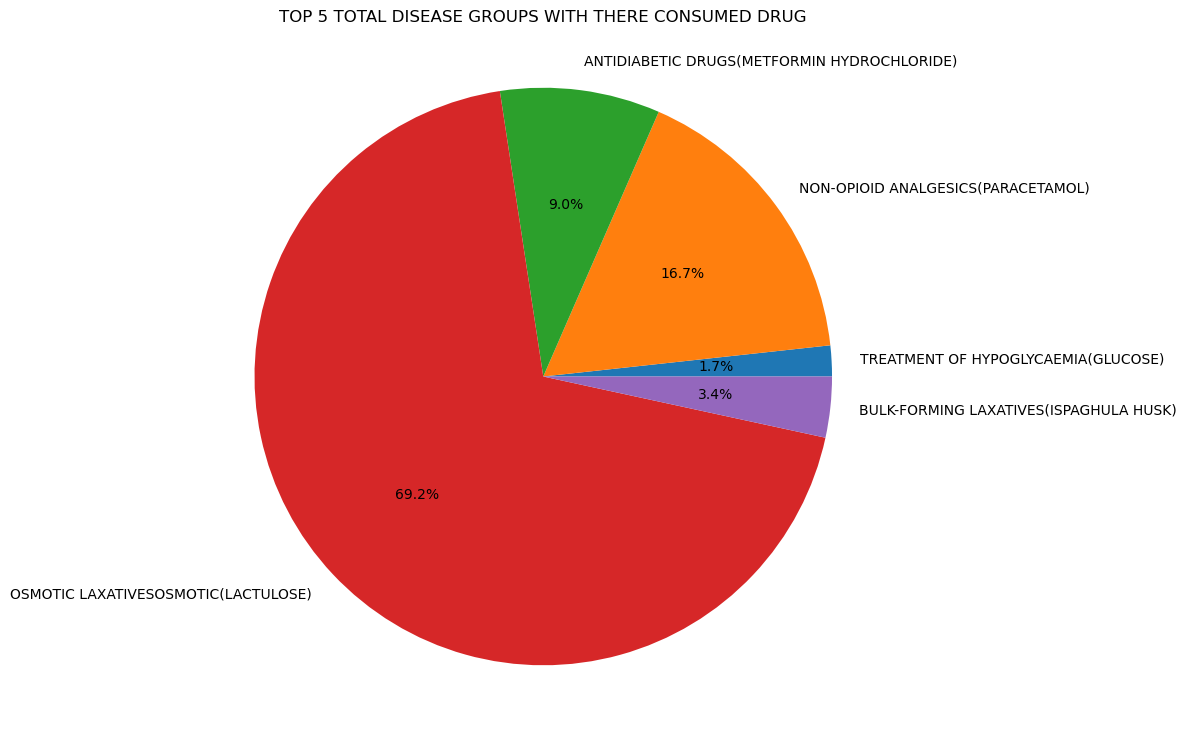

In [23]:
plt.figure(figsize=(8,9))
plt.pie(BNF_sub_section['Consumed_Drug(KG)'], labels=BNF_sub_section['Condition'], autopct='%1.1f%%')
plt.title('TOP 5 TOTAL DISEASE GROUPS WITH THERE CONSUMED DRUG')
plt.axis('equal')

# for i, (_, label) in enumerate(BNF.iterrows()):
#     plt.text(0, 0, f"{label['Condition']}: {label['Consumed_Drug(KG)']:.2f}", ha='center', va='center')
# Slant the labels
plt.gca().set_aspect("equal")
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_xlim(-1.2, 1.2)
plt.gca().set_ylim(-1.2, 1.2)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_rotation(45)
plt.show()

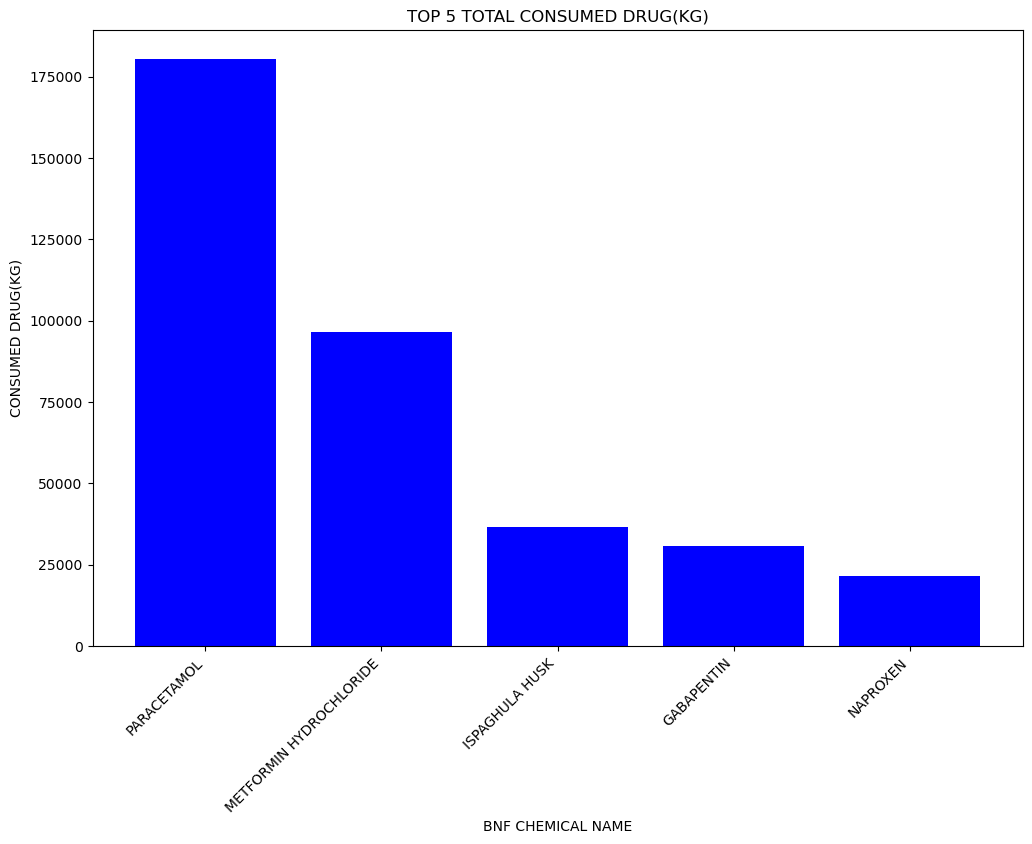

In [24]:
A = total_consumed_drug.drop(total_consumed_drug[(total_consumed_drug["BNF chemical name"]== "LACTULOSE") | (total_consumed_drug["BNF chemical name"] == "GLUCOSE")]. index)
A.head()

top_5 = A.head(5)
plt.figure(figsize = (12, 8))
plt.bar(top_5["BNF chemical name"], top_5["Consumed_Drug(KG)"], color = "blue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("BNF CHEMICAL NAME")
plt.ylabel("CONSUMED DRUG(KG)")
plt.title("TOP 5 TOTAL CONSUMED DRUG(KG)")
 
plt.show();

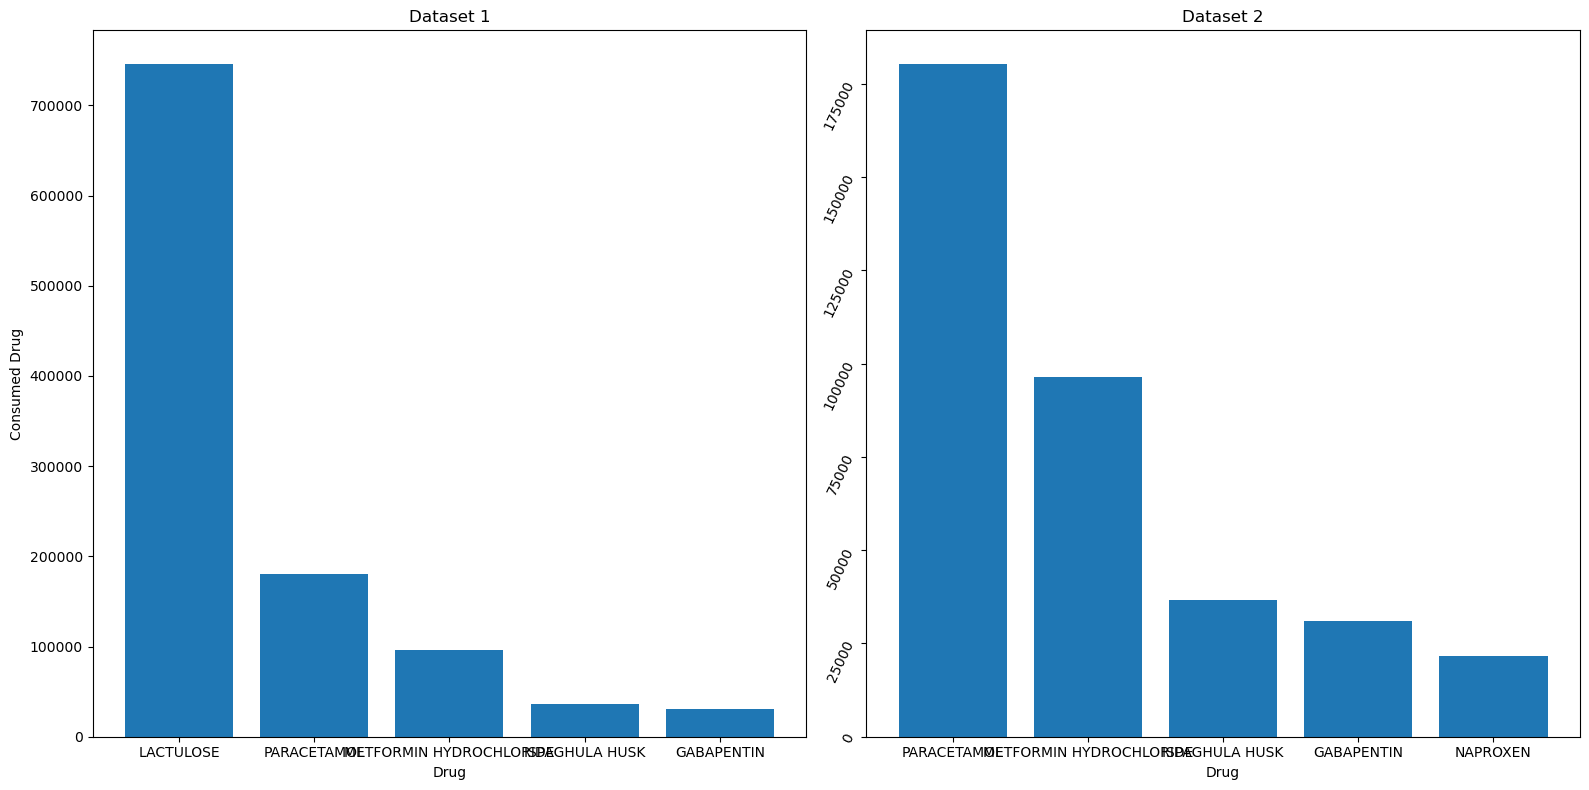

In [25]:
data1 = {"Drug": ["LACTULOSE", "PARACETAMOL", "METFORMIN HYDROCHLORIDE", "ISPAGHULA HUSK", "GABAPENTIN" ],
         "Consumed_Drug": [745864.885000, 180319.679770, 96479.794512, 36654.487830, 30898.145400]}
data2 =  {"Drug": ["PARACETAMOL", "METFORMIN HYDROCHLORIDE", "ISPAGHULA HUSK", "GABAPENTIN", "NAPROXEN"],
         "Consumed_Drug": [180319.679770, 96479.794512, 36654.487830, 30898.145400, 21547.092000]}

# Create Figure and Axes objects for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
# plt.xticks(rotation=45, ha="right")

# Plot for Dataset 1
axes[0].bar(data1['Drug'], data1['Consumed_Drug'])
axes[0].set_title('Dataset 1')
axes[0].set_xlabel('Drug')
axes[0].set_ylabel('Consumed Drug')
plt.yticks(rotation=45, ha="right")
# Plot for Dataset 2
axes[1].bar(data2['Drug'], data2['Consumed_Drug'])
axes[1].set_title('Dataset 2')
axes[1].set_xlabel('Drug')
# axes[1].set_ylabel('Consumed Drug')
plt.yticks(rotation=65, ha="right")
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [26]:

# data1 = {"Drug": ["LACTULOSE", "PARACETAMOL", "METFORMIN HYDROCHLORIDE", "ISPAGHULA HUSK", "GABAPENTIN" ],
#          "Consumed_Drug": [745864.885000, 180319.679770, 96479.794512, 36654.487830, 30898.145400]}
# data2 =  {"Drug": ["PARACETAMOL", "METFORMIN HYDROCHLORIDE", "ISPAGHULA HUSK", "GABAPENTIN", "NAPROXEN"],
#          "Consumed_Drug": [180319.679770, 96479.794512, 36654.487830, 30898.145400, 21547.092000]}

# # Create Figure and Axes objects for subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# # Plot for Dataset 1
# axes[0].bar(data1['Drug'], data1['Consumed_Drug'])
# axes[0].set_title('Dataset 1')
# axes[0].set_xlabel('Consumed Drug')
# axes[0].set_ylabel('Drug')
# axes[0].invert_yaxis()  # Invert the y-axis to display the bars from top to bottom

# # Plot for Dataset 2
# axes[1].bar(data2['Drug'], data2['Consumed_Drug'])
# axes[1].set_title('Dataset 2')
# axes[1].set_xlabel('Consumed Drug')
# axes[1].invert_yaxis()  # Invert the y-axis to display the bars from top to bottom

# # Adjust spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()

In [27]:
# data1 = {
#     "Drug": ["LACTULOSE", "PARACETAMOL", "METFORMIN HYDROCHLORIDE", "ISPAGHULA HUSK", "GABAPENTIN"],
#     "Consumed_Drug": [745864.885000, 180319.679770, 96479.794512, 36654.487830, 30898.145400]
# }

# data2 = {
#     "Drug": ["PARACETAMOL", "METFORMIN HYDROCHLORIDE", "ISPAGHULA HUSK", "GABAPENTIN", "NAPROXEN"],
#     "Consumed_Drug": [180319.679770, 96479.794512, 36654.487830, 30898.145400, 21547.092000]
# }

# # Create Figure and Axes objects for subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# # Plot for Dataset 1
# axes[0].bar(data1['Drug'], data1['Consumed_Drug'])  # Swap 'Drug' and 'Consumed_Drug' in bar function
# axes[0].set_title('Dataset 1')
# axes[0].set_xlabel('Drug')
# axes[0].set_ylabel('Consumed Drug')

# # Plot for Dataset 2
# axes[1].bar(data2['Drug'], data2['Consumed_Drug'])  # Swap 'Drug' and 'Consumed_Drug' in bar function
# axes[1].set_title('Dataset 2')
# axes[1].set_xlabel('Drug')
# axes[1].set_ylabel('Consumed Drug')

# # Adjust spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_9660\1864396549.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(data1['Drug'], rotation=45, ha='right')
C:\Users\HP\AppData\Local\Temp\ipykernel_9660\1864396549.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(data2['Drug'], rotation=45, ha='right')


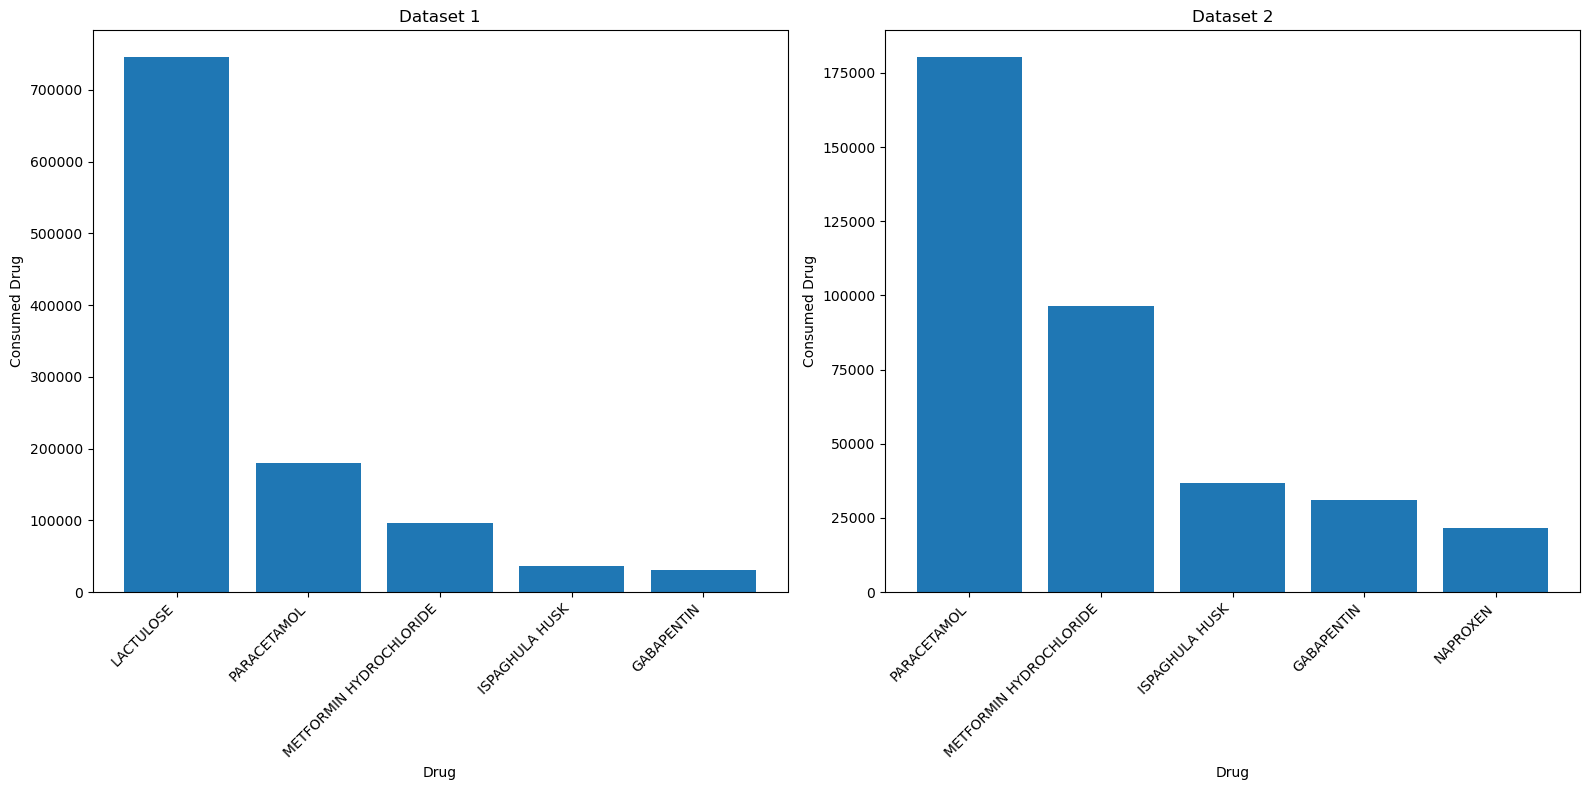

In [28]:
import matplotlib.pyplot as plt

data1 = {
    "Drug": ["LACTULOSE", "PARACETAMOL", "METFORMIN HYDROCHLORIDE", "ISPAGHULA HUSK", "GABAPENTIN"],
    "Consumed_Drug": [745864.885000, 180319.679770, 96479.794512, 36654.487830, 30898.145400]
}

data2 = {
    "Drug": ["PARACETAMOL", "METFORMIN HYDROCHLORIDE", "ISPAGHULA HUSK", "GABAPENTIN", "NAPROXEN"],
    "Consumed_Drug": [180319.679770, 96479.794512, 36654.487830, 30898.145400, 21547.092000]
}

# Create Figure and Axes objects for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot for Dataset 1
axes[0].bar(data1['Drug'], data1['Consumed_Drug'])
axes[0].set_title('Dataset 1')
axes[0].set_xlabel('Drug')
axes[0].set_ylabel('Consumed Drug')
axes[0].set_xticklabels(data1['Drug'], rotation=45, ha='right')

# Plot for Dataset 2
axes[1].bar(data2['Drug'], data2['Consumed_Drug'])
axes[1].set_title('Dataset 2')
axes[1].set_xlabel('Drug')
axes[1].set_ylabel('Consumed Drug')
axes[1].set_xticklabels(data2['Drug'], rotation=45, ha='right')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

<Axes: >

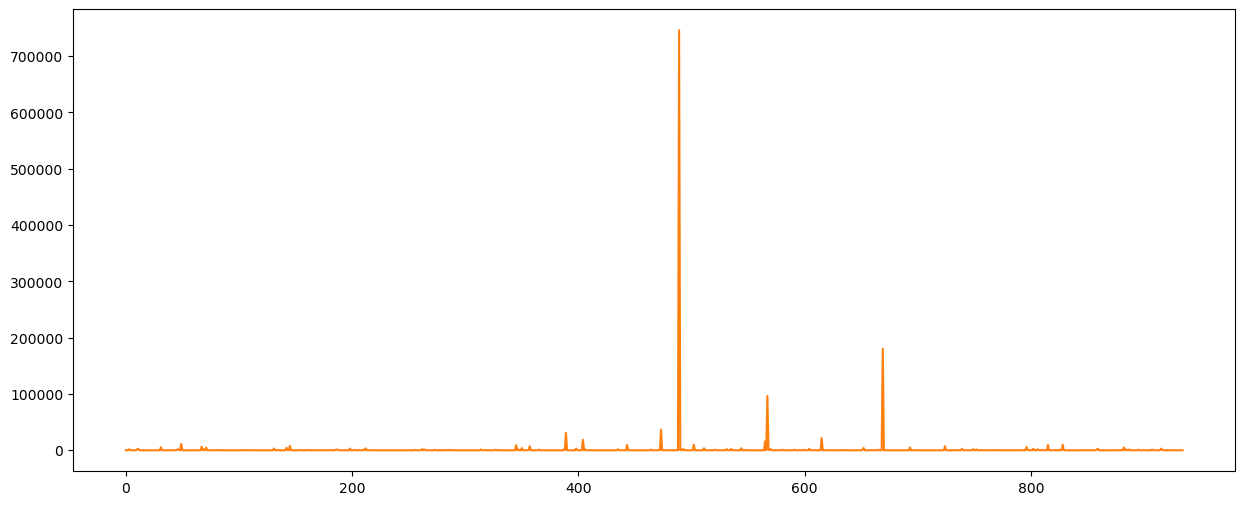

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot Consumed_Drug(KG)
df_fina["Consumed_Drug(KG)"].plot(ax=ax, label="Consumed_Drug(KG)", color="C1")

<Axes: >

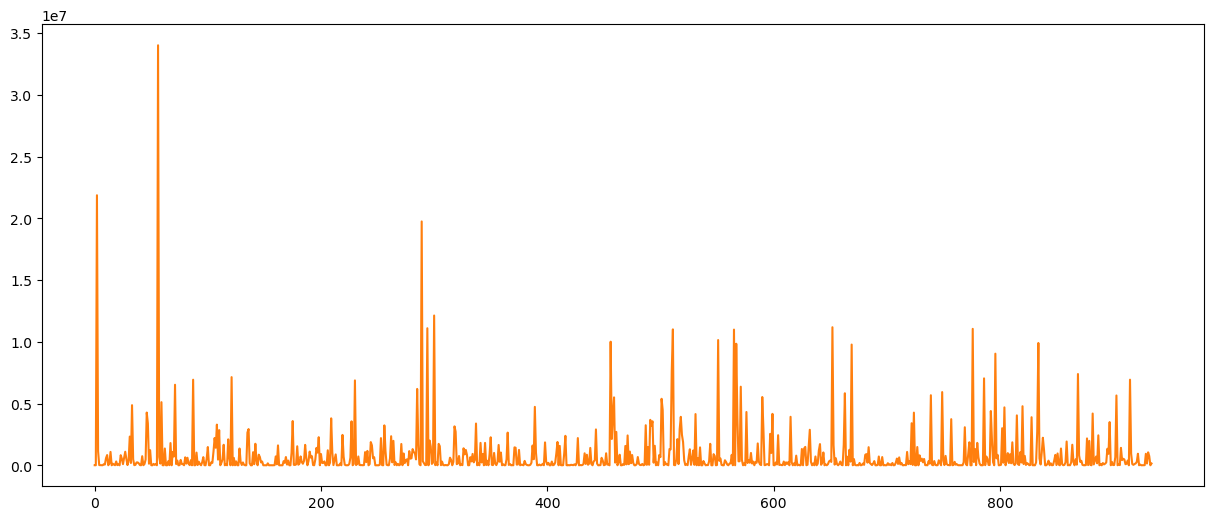

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot Gross ingredient cost (£)price
df_fina["Gross ingredient cost (£)"].plot(ax=ax,  color="C1")

<Axes: >

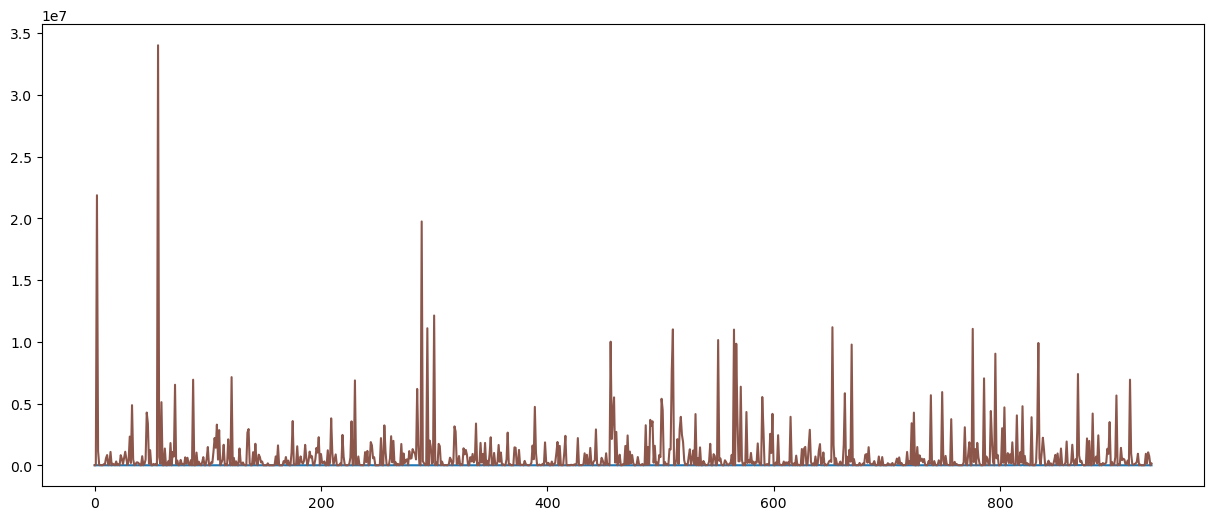

In [38]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot Gross ingredient cost (£)price
# 
df_fina["Cost per item (£)"].plot(ax=ax,  label = "Cost per item (£)")
df_fina["Gross ingredient cost (£)"].plot(ax=ax,  label = "Gross ingredient cost (£)", color = "C5" )

<Axes: >

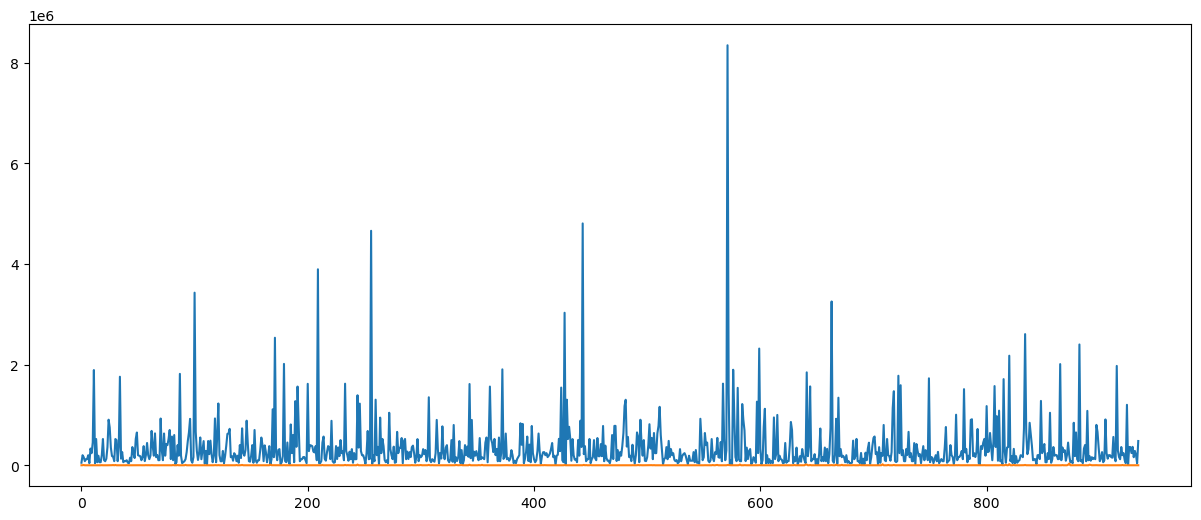

In [45]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot Gross ingredient cost (£)price
# 
df_fina["BNF sub-section.1"].plot(ax=ax,  label = "BNF sub-section.1")
#df_fina["Gross ingredient cost (£)"].plot(ax=ax,  label = "Gross ingredient cost (£)", color = "C5" )
df_fina["Cost per item (£)"].plot(ax=ax,  label = "Cost per item (£)")